<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [36]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [37]:
# webdown not working
#!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

# Read Data (downloaded from web)
#pd.read_csv(r"C:\Users\un616h\OneDrive - AT&T Services, Inc\Documents\ATT_Work_Related\Training\Python_Training (Self Study)\Mchine_Learning_with_Python\loan_train (web-1).csv")

### Load Data From CSV File


In [38]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [39]:
df.shape

(346, 10)

### Convert to date time object


In [40]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [41]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [78]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y


CondaHTTPError: HTTP 000 CONNECTION FAILED for url <https://conda.anaconda.org/anaconda/win-64/current_repodata.json>
Elapsed: -

An HTTP error occurred when trying to retrieve this URL.
HTTP errors are often intermittent, and a simple retry will get you on your way.
'https://conda.anaconda.org/anaconda/win-64'




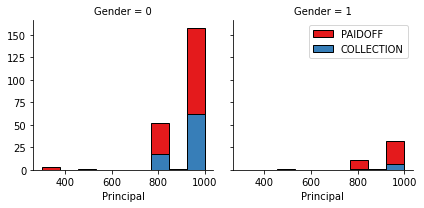

In [79]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

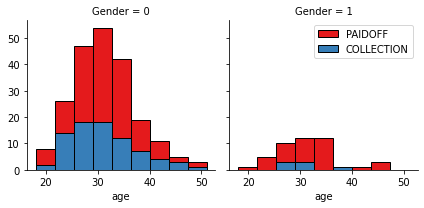

In [80]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


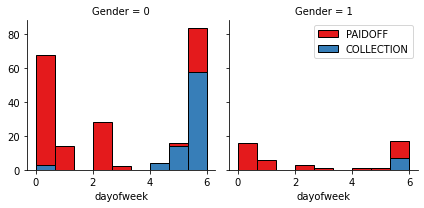

In [81]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [82]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [83]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
0       PAIDOFF        0.731293
        COLLECTION     0.268707
1       PAIDOFF        0.865385
        COLLECTION     0.134615
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [84]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

## One Hot Encoding

#### How about education?


In [85]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [86]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [87]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [88]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [89]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [90]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [91]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [92]:
from sklearn.neighbors import KNeighborsClassifier

In [93]:
# k = 4
k = 7
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(n_neighbors=7)

In [94]:
yhat = neigh.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [95]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8079710144927537
Test set Accuracy:  0.7857142857142857


In [96]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286])

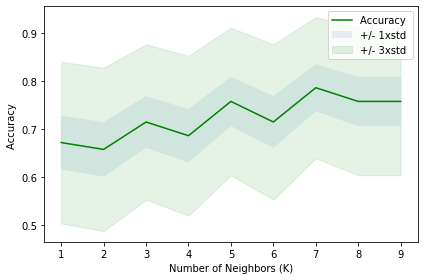

In [97]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [98]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7857142857142857 with k= 7


# Decision Tree


In [99]:
from sklearn.tree import DecisionTreeClassifier

In [100]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree # it shows the default parameters

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [101]:
loanTree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [102]:
predTree = loanTree.predict(X_test)

In [103]:
print (predTree [0:5])
print (y_test [0:5])

['COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [104]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.6142857142857143


In [105]:
#pip install pydotplus

In [106]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

ModuleNotFoundError: No module named 'pydotplus'

In [107]:
dot_data = StringIO()
filename = "drugtree.png"
featureNames = my_data.columns[0:5]
out=tree.export_graphviz(drugTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

NameError: name 'my_data' is not defined

# Support Vector Machine


In [108]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC()

In [109]:
yhat = clf.predict(X_test)
yhat [0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [110]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [111]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Confusion matrix, without normalization
[[48  7]
 [11  4]]


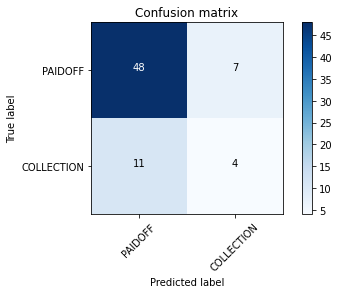

In [112]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [113]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted')

0.7275882012724117

In [114]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,pos_label='PAIDOFF')

0.7272727272727273

# Logistic Regression


In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [116]:
yhat = LR.predict(X_test)
yhat

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF'], dtype=object)

In [117]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.5 , 0.5 ],
       [0.45, 0.55],
       [0.31, 0.69],
       [0.34, 0.66],
       [0.32, 0.68],
       [0.32, 0.68],
       [0.49, 0.51],
       [0.48, 0.52],
       [0.34, 0.66],
       [0.49, 0.51],
       [0.34, 0.66],
       [0.5 , 0.5 ],
       [0.25, 0.75],
       [0.34, 0.66],
       [0.44, 0.56],
       [0.26, 0.74],
       [0.52, 0.48],
       [0.3 , 0.7 ],
       [0.5 , 0.5 ],
       [0.32, 0.68],
       [0.44, 0.56],
       [0.49, 0.51],
       [0.51, 0.49],
       [0.47, 0.53],
       [0.41, 0.59],
       [0.51, 0.49],
       [0.51, 0.49],
       [0.37, 0.63],
       [0.5 , 0.5 ],
       [0.25, 0.75],
       [0.47, 0.53],
       [0.46, 0.54],
       [0.46, 0.54],
       [0.48, 0.52],
       [0.39, 0.61],
       [0.46, 0.54],
       [0.5 , 0.5 ],
       [0.29, 0.71],
       [0.46, 0.54],
       [0.45, 0.55],
       [0.51, 0.49],
       [0.32, 0.68],
       [0.45, 0.55],
       [0.51, 0.49],
       [0.31, 0.69],
       [0.5 , 0.5 ],
       [0.47, 0.53],
       [0.5 ,

In [118]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,pos_label='PAIDOFF')

0.6764705882352942

In [119]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=['COLLECTION','PAIDOFF']))

[[ 2 13]
 [ 9 46]]


Confusion matrix, without normalization
[[ 2 13]
 [ 9 46]]


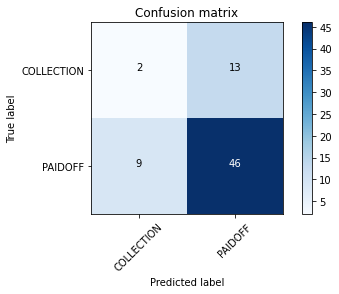

In [120]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['COLLECTION','PAIDOFF'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix')

# Model Evaluation using Test set


In [121]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [122]:
# webdown not working
#!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

# Read (Test) Data (downloaded from web)
#pd.read_csv(r"C:\Users\un616h\OneDrive - AT&T Services, Inc\Documents\ATT_Work_Related\Training\Python_Training (Self Study)\Mchine_Learning_with_Python\loan_test (web-1) - USE.csv")

### Load Test set for evaluation


In [123]:
test_df = pd.read_csv('loan_test (web-1) - USE.csv')
test_df.head()

,id,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [124]:
test_df.shape

(54, 10)

In [125]:
# Convert to date time object
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,id,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [126]:
# how many of each class is in test data set
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

In [127]:
# Pre-processing: Feature selection/extraction
# Dates
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,id,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [128]:
# Convert Categorical features to numerical values
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,id,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [129]:
# Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [130]:
# Feature Selection
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [131]:
# labels (Target)
y = test_df['loan_status'].values
y[0:50]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION'], dtype=object)

In [132]:
# Normalize Data
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.49,  0.93,  3.06,  1.98, -1.3 ,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.77,  2.4 , -0.8 , -0.86]])

In [138]:
# KNN Model on Test Data
yhat = neigh.predict(X)
yhat[0:5]

print("KNN Model Results: On Test Data")

from sklearn import metrics
print("Test set Accuracy: ", metrics.accuracy_score(y, yhat))
knn_acc = metrics.accuracy_score(y, yhat)

from sklearn.metrics import jaccard_score
print("Test set jaccard: ", jaccard_score(y, yhat,pos_label='PAIDOFF'))
knn_jac = jaccard_score(y, yhat,pos_label='PAIDOFF')

from sklearn.metrics import f1_score
print("Test set f1 score: ", f1_score(y, yhat, average='weighted'))
knn_f1s = f1_score(y, yhat, average='weighted')

KNN Model Results: On Test Data
Test set Accuracy:  0.7037037037037037
Test set jaccard:  0.6862745098039216
Test set f1 score:  0.6736355806123249


In [139]:
# Decision Tree Model on Test Data
yhat = loanTree.predict(X)
yhat[0:5]

print("Decision Tree Model Results: On Test Data")

from sklearn import metrics
print("Test set Accuracy: ", metrics.accuracy_score(y, yhat))
dt_acc = metrics.accuracy_score(y, yhat)

from sklearn.metrics import jaccard_score
print("Test set jaccard: ", jaccard_score(y, yhat,pos_label='PAIDOFF'))
dt_jac = jaccard_score(y, yhat,pos_label='PAIDOFF')

from sklearn.metrics import f1_score
print("Test set f1 score: ", f1_score(y, yhat, average='weighted'))
dt_f1s = f1_score(y, yhat, average='weighted')


Decision Tree Model Results: On Test Data
Test set Accuracy:  0.7222222222222222
Test set jaccard:  0.6590909090909091
Test set f1 score:  0.7366818873668188


In [140]:
# SVM Model on Test Data
yhat = clf.predict(X)
yhat[0:5]

print("SVM Model Results: On Test Data")

from sklearn import metrics
print("Test set Accuracy: ", metrics.accuracy_score(y, yhat))
svm_acc = metrics.accuracy_score(y, yhat)

from sklearn.metrics import jaccard_score
print("Test set jaccard: ", jaccard_score(y, yhat,pos_label='PAIDOFF'))
svm_jac = jaccard_score(y, yhat,pos_label='PAIDOFF')

from sklearn.metrics import f1_score
print("Test set f1 score: ", f1_score(y, yhat, average='weighted'))
svm_f1s = f1_score(y, yhat, average='weighted')

SVM Model Results: On Test Data
Test set Accuracy:  0.7962962962962963
Test set jaccard:  0.78
Test set f1 score:  0.7583503077293734


In [141]:
# Logistic Regression Model on Test Data
yhat = LR.predict(X)
yhat[0:5]
yhat_prob = LR.predict_proba(X)
yhat_prob[0:5]

print("Logistic Regression Model Results: On Test Data")

from sklearn import metrics
print("Test set Accuracy: ", metrics.accuracy_score(y, yhat))
lr_acc = metrics.accuracy_score(y, yhat)

from sklearn.metrics import jaccard_score
print("Test set jaccard: ", jaccard_score(y, yhat,pos_label='PAIDOFF'))
lr_jac = jaccard_score(y, yhat,pos_label='PAIDOFF')

from sklearn.metrics import f1_score
print("Test set f1 score: ", f1_score(y, yhat, average='weighted'))
lr_f1s = f1_score(y, yhat, average='weighted')

from sklearn.metrics import log_loss
print("Test set log loss: ", log_loss(y, yhat_prob))
lr_log = log_loss(y, yhat_prob)

Logistic Regression Model Results: On Test Data
Test set Accuracy:  0.7407407407407407
Test set jaccard:  0.7358490566037735
Test set f1 score:  0.6604267310789049
Test set log loss:  0.5672153379912981


In [137]:
print("Best performing Model is : SVM with K = 7  (based on Accuracy, also Jaccard & F1-Score)", )

Best performing Model is : SVM with K = 7  (based on Accuracy, also Jaccard & F1-Score)


In [167]:
print('Various models built and their evaluation metrics for accuracy:')
print("| Algorithm          | Accuracy | Jaccard | F1-score | LogLoss |")
print("| ------------------ | -------- | --------| -------- | --------|")
print("| KNN                | {}    | {}   | {}    | NA      |".format(round(knn_acc,3) , round(knn_jac,3) , round(knn_f1s,3)))
print("| Decision Tree      | {}    | {}   | {}    | NA      |".format(round(dt_acc,3) , round(dt_jac,3) , round(dt_f1s,3)))
print("| SVM                | {}    | {}    | {}    | NA      |".format(round(svm_acc,3) , round(svm_jac,3) , round(svm_f1s,3)))
print("| LogisticRegression | {}    | {}   | {}     | {}   |".format(round(lr_acc,3) , round(lr_jac,3) , round(lr_f1s,3) , round(lr_log,3)))

Various models built and their evaluation metrics for accuracy:
| Algorithm          | Accuracy | Jaccard | F1-score | LogLoss |
| ------------------ | -------- | --------| -------- | --------|
| KNN                | 0.704    | 0.686   | 0.674    | NA      |
| Decision Tree      | 0.722    | 0.659   | 0.737    | NA      |
| SVM                | 0.796    | 0.78    | 0.758    | NA      |
| LogisticRegression | 0.741    | 0.736   | 0.66     | 0.567   |


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
